# Perform analyses of 400-member prior/truth reconstructions.

In [2]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [3]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import matplotlib

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['font.family'] = 'Arial'


Loading information from datasets.yml
Loading information from grid_def.yml


# Define routines for processing

In [4]:
# Load and interpolate all of the priors I want to use as truth

def mk_ad(lmr_names,model_names):
    
    # Initialize an array of various interpolated model fields
    ad = []

    for ii in np.arange(len(lmr_names)):
        dd = {}
        cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        X, Xb_one = LMRlite.load_prior(cfg)
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        # check if config is set to regrid the prior
        if cfg.prior.regrid_method:
            print('regridding prior...')
            # this function over-writes X, even if return is given a different name
            [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
        else:
            X.trunc_state_info = X.full_state_info

        Xb_one = Xb_one_new
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        dd['X']            = X
        dd['Xbp']          = Xbp
        dd['name']         = model_names[ii]
        dd['lmr_name']     = lmr_names[ii]
        dd['grid']         = LMRlite.Grid(X)
        dd['prox_manager'] = LMRlite.load_proxies(cfg)
        dd['numprox']      = len(LMRlite.load_proxies(cfg).all_proxies) 

        print(ii)
        print(dd['name'])

        ad.append(dd)
        
    return ad

In [5]:
def mk_yes(X,Xbp,prox_manager,grid):
    
    [_,nens] = Xbp.shape
    numprox = len(prox_manager.ind_assim)
    vYe = np.zeros([numprox,nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords

# Define plotting routines

In [186]:
# Plot RMS error

def plt_var2(cdd,savename):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(4,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,1),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = [0,4,8]

    for jj, ax in enumerate(axgr):
        rmsc = cdd[tt_ax[jj]]['rmse']

        cldat = rmsc.reshape(grid.nlat,grid.nlon)**2
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=2.,vmin=0.,
                        transform=projection,
                        cmap='inferno_r',
                        )
        
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])
        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    #plt.show()
    plt.savefig(savename+'_1.png',bbox_inches='tight',dpi=300)
    
    #############

    fig = plt.figure(figsize=(9,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    tt_eq  = [0,4,8,0,4,8]
    switch = [0,3,1,4,2,5]
    
    vmin = -1.0
    vmax = 1.0

    
    
    for j, ax in enumerate(axgr):
        jj = switch[j]
        rmsc = cdd[ntt_ax[jj]]['rmse']
        rt   = cdd[tt_eq[jj]]['rmse']
        
        cldat = rmsc.reshape(grid.nlat,grid.nlon)**2-rt.reshape(grid.nlat,grid.nlon)**2
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[j])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=vmax,vmin=vmin,
                        transform=projection,
                        cmap='RdBu_r'
                        )
        
        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'])

        #plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
        #          '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
     
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off

    cb=axgr.cbar_axes[0].colorbar(p)
    cb.ax.set_xticks(np.arange(-1.,1.25,.25))  
    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)

In [187]:
# Plot noise to signal ratios (variance)

def plt_n2s(cdd,Xd,savename):
    
    VM = 1.5
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']


    # Compute mean truth variances over 3 realizations each
    key = np.array([[0,1,2],[3,4,5],[6,7,8]])
    tvar = np.zeros([3,91*180])*np.nan
    for ii in np.arange(3):
        tvar[ii,:] = np.mean(np.var(Xd[key[ii,:],:,:],2),0)
    
    fig = plt.figure(figsize=(4,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,1),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = [0,4,8]

    for jj, ax in enumerate(axgr):
        evar = cdd[tt_ax[jj]]['rmse']
        
        #cldat = (evar/tvar[jj,:]**.5).reshape(grid.nlat,grid.nlon)
        
        # N2S as a ratio of variances
        cldat = (evar**2/tvar[jj,:]).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=0.,
                        transform=projection,
                        cmap='inferno_r',
                        )
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])

        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

    cb=axgr.cbar_axes[0].colorbar(p)
    plt.savefig(savename+'_1.png',bbox_inches='tight',dpi=300)
    
    #############

    fig = plt.figure(figsize=(9,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    # Indices of truth experiments
    tt_eq  = [0,4,8,0,4,8]
    tvari  = [0,1,2,0,1,2]

    # Switch row/column order of plotting
    switch = [0,3,1,4,2,5]
    
    vmin = -1.
    vmax =  1.

    cmap = 'RdBu_r' 
    
    for j, ax in enumerate(axgr):

        jj = switch[j]
        rmsc = cdd[ntt_ax[jj]]['rmse']
        rt   = cdd[tt_eq[jj]]['rmse']
        
        #cldat = ((rmsc-rt)/tvar[tvari[jj]]**.5).reshape(grid.nlat,grid.nlon)
        # NSR as a ratio of variances
        cldat = ((rmsc**2-rt**2)/tvar[tvari[jj]]).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[j])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=vmax,vmin=vmin,
                        transform=projection,
                        cmap='RdBu_r'
                        )

        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'])

        #plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
        #          '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
     
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    cb.ax.set_xticks(np.arange(-1,1.25,.25))
    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)

In [188]:
# Plot normalized error (std dev divided by std dev of posterior)

def plt_NE(cdd,savename):
    
    VM = 1.5
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(4,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,1),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = [0,4,8]

    for jj, ax in enumerate(axgr):
        evar = cdd[tt_ax[jj]]['rmse']
        pa   = cdd[tt_ax[jj]]['Xastd']
        #cldat = (evar/tvar[jj,:]**.5).reshape(grid.nlat,grid.nlon)
        
        # N2S as a ratio of variances
        cldat = (evar/pa).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[jj])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=0.,
                        transform=projection,
                        cmap='inferno_r',
                        )
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])

        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

    cb=axgr.cbar_axes[0].colorbar(p)
    plt.savefig(savename+'_1.png',bbox_inches='tight',dpi=300)
    
    #############

    fig = plt.figure(figsize=(9,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    # Indices of truth experiments
    tt_eq  = [0,4,8,0,4,8]
    tvari  = [0,1,2,0,1,2]

    # Switch row/column order of plotting
    switch = [0,3,1,4,2,5]
    
    vmin = -1.
    vmax =  1.

    cmap = 'RdBu_r' 
    
    for j, ax in enumerate(axgr):

        jj = switch[j]
        rmsc = cdd[ntt_ax[jj]]['rmse']
        pa   = cdd[ntt_ax[jj]]['Xastd']

        rt   = cdd[tt_eq[jj]]['rmse']
        pat  = cdd[tt_eq[jj]]['Xastd']

        
        #cldat = ((rmsc-rt)/tvar[tvari[jj]]**.5).reshape(grid.nlat,grid.nlon)
        # NSR as a ratio of variances
        cldat = (rmsc/pa-rt/pat).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[j])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=vmax,vmin=vmin,
                        transform=projection,
                        cmap='RdBu_r'
                        )

        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'])

        #plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
        #          '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
     
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    cb.ax.set_xticks(np.arange(-1,1.25,.25))
    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)

In [189]:
# Plot fraction of error

def plt_FOE(cdd,Xd,savename):
    
    VM = 1.
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']


    # Compute mean truth variances over 3 realizations each
    key = np.array([[0,1,2],[3,4,5],[6,7,8]])
    tvar = np.zeros([3,91*180])*np.nan
    for ii in np.arange(3):
        tvar[ii,:] = np.mean(np.var(Xd[key[ii,:],:,:],2),0)
    
    fig = plt.figure(figsize=(9,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    ntt_ax = [1,3,6,2,5,7]
    # Indices of truth experiments
    tt_eq  = [0,4,8,0,4,8]
    tvari  = [0,1,2,0,1,2]
    # Switch row/column order of plotting
    switch = [0,3,1,4,2,5]

    vmin = -1.0
    vmax = 1.0

    cmap = 'RdBu_r' 
    
    for j, ax in enumerate(axgr):
        jj = switch[j]
        
        # RMSE of an experiment
        rmsc = cdd[ntt_ax[jj]]['rmse']
        # RMSE of experiment with the same truth case where the prior is drawn from the same distribution as the truth
        rt   = cdd[tt_eq[jj]]['rmse']
        
        cldat = ((rmsc**2-rt**2)/rmsc**2).reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[j])

        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=VM,vmin=-VM,
                        transform=projection,
                        cmap='RdBu_r'
                        )

        plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'])
        #plt.title('Prior: '+ cdd[ntt_ax[jj]]['prior_name'] + ', truth: ' + cdd[ntt_ax[jj]]['truth_name'] +
        #          '\n minus Prior: '+ cdd[tt_eq[jj]]['prior_name'] + ', truth: ' + cdd[tt_eq[jj]]['truth_name'])
        
        ax.coastlines(color='gray')
        ax.grid(which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['pind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

        if np.mod(j,2)!=0:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                labelleft=False) # labels along the bottom edge are off
        
    cb=axgr.cbar_axes[0].colorbar(p)
    cb.ax.set_xticks(np.arange(-1.,1.25,.25))  
    plt.savefig(savename+'.png',bbox_inches='tight',dpi=300)

In [190]:
# Plot normalized (Pa) error, this time not differences but full values

def plt_NE2(cdd,Xd,savename):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(14,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,3),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = np.arange(9)

    #switch = [0,3,6,1,4,7,2,5,8]
    switch = [0,1,2,4,3,5,8,6,7]
    for ii, ax in enumerate(axgr):
        jj = switch[ii]
        
        rmsc = np.log2(np.std(cdd[tt_ax[jj]]['Xa'],1)**2 /cdd[tt_ax[jj]]['rmse']**2)

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=3.,vmin=-3.,
                        transform=projection,
                        cmap='RdBu_r',
                        )
        
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])
        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['tind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

#        if cdd[jj]['pind']!=0:
        if cdd[jj]['pind']!=cdd[jj]['tind']:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                right=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    #cb.ax.set_xticks(np.log2(np.array([1/4,1/2,1,2,4])))
    #cb.ax.set_xticklabels(['1/4','1/2','1','2','4'])
    cb.ax.set_xticks(np.log2(np.array([1/8,1/4,1/2,1,2,4,8])))
    cb.ax.set_xticklabels(['1/8','1/4','1/2','1','2','4','8'])
    #cb.ax.set_xticks(np.log10(np.array([1/10,1/5,1/2,1,2,5,10])))
    #cb.ax.set_xticklabels(['1/10','1/5','1/2','1','2','5','10'])


    plt.savefig(savename+'.png',bbox_inches='tight',dpi=300)
    plt.show()
    
#    bins    = np.linspace(-8,8,100)
#    bincs   = bins[:-1]+np.median(np.diff(bins))
#    counts  = np.empty([9,len(bins)-1])
    
#    for jj in np.arange(9):
#        hists = ((cdd[jj]['recon']-Xd[jj])/np.std(cdd[jj]['Xa'],1)[:,None]).ravel()
#        counts[jj,:] = np.histogram(hists,bins)[0]
#    plt.plot(bincs,counts.T)
#    plt.show()
#    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)
#    return bincs, counts

In [191]:
# Function to test hypothesis about what sets localization

def mkresplot(ad,obind):

    import LMR_lite_utils as LMRlite
    import LMR_utils
    import LMR_config
    import numpy as np
    import os,sys
    from time import time
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature
    from cartopy.util import add_cyclic_point
    %matplotlib inline
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm
    
    NB = 100
    Nens = 60
    # Pick an ob location

    grid = ad[0]['grid']
    
    # "truth"
    ii = 0
    vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],ad[ii]['prox_manager'],ad[ii]['grid'])

    # Make a map of distances (good for both prior and truth)
    var = list(ad[ii]['X'].statevars.keys())[0]
    X_lat = ad[ii]['X'].prior_dict[var]['lat']
    X_lon = ad[ii]['X'].prior_dict[var]['lon']

    # Wrap before computing dists to help with contours below
    X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
    X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
    #distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
    dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

    # Compute regressions in distance range for two models and save
    # "prior"
    jjj = 1
    vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],ad[jjj]['prox_manager'],ad[jjj]['grid'])

    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])


    # Define a range of distances
    drange = np.linspace(0,20000,NB)

    # Loop through distance ranges
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
    r2_lat = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
    r2 = (np.reshape(diffs,[grid.nlat,grid.nlon]))
    r1 = [] # mean
    rv = [] # var
    for jj in np.arange(len(drange)-1):
        r1.append( np.sum( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]*np.sin(np.deg2rad(np.abs(grid.lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ])))));
        rv.append( np.var( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));

    # Need to normalize by variance!

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    fig = plt.figure(figsize=(8,4))

    r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],r2w/np.max(r2w),cmap='YlOrRd')#,vmin=-5,vmax=1)
    ax.coastlines(color='gray')
    CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
    ax.clabel(CS,fmt='%r')
    print(np.max(r2w))

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.ylabel(' \n ')

    #sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(np.min(r2w),np.max(r2w)))
    #sm._A = []
    #plt.colorbar(sm,ax=ax)
 
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
     
    ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/reg_error_'+model_names[ii]+'_'+model_names[jjj]+str(obind)+'.pdf')
    plt.tight_layout
    plt.show()

    return drange, r1


In [192]:
def plotswarm(gmp,col):
    si = 15
    fig = plt.figure(figsize=(4,6))
    sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=[col])
    plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
    plt.xlabel('Localization radius (km)')
    plt.xticks(rotation=45,ha="right")
    plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([0.24,0.36])
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.2, .7), loc=2, borderaxespad=0.,frameon=True)
    #plt.tight_layout()
    
    # For final paper figure
    plt.grid()
    ax.legend_.remove()



In [193]:
def mk_regmeans_Xa(cdd,Xd):

    # Compute regional means for the random draws case.

    # Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
    # Arctic: >60
    # Antarctic: >60
    # N America: 30-55 N, 135-75 W
    # S America: 66-20 S, 82-37 W
    # Europe: 37 - 70 N, 7W - 40 E
    # Asia: 23-47 N, 60-165E
    # Australasia: 50-0S, 120-180 E

    SNR = 0.4
    LOCRAD = 0.0

    lats = cdd[0]['grid'].lat
    lons = cdd[0]['grid'].lon
    nlat = cdd[0]['grid'].nlat
    nlon = cdd[0]['grid'].nlon
    Inf = np.inf

    # Mins and maxes defined looking from left to right on the globe
    regnames = ['NH','SH','Arctic', 'Antarctic','N. America','S. America','Europe','Asia','Australasia','Global']
    reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50,-Inf]
    reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0,Inf]
    reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120,-Inf]
    reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180,Inf]

    wtmaps = np.tile(np.nan*np.ones([nlat,nlon]),[len(regnames),1,1])
    allmap_std_ps = np.nan*np.ones([nlat,nlon])

    std_ps = np.nan*np.ones([len(cdd),len(regnames)])

    gmps = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])
    gmpl = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])
    #gmp = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

    # indices of regions with relatively large and small error variances. Separating for plotting.
    leri = np.array([3,5])
    seri = np.array([0,1,2,4,6,7,8,9])
    
    # indices of truth-truth experiments corresponding to each prior-truth (to use for FOE)
    tti  = np.array([0, 0, 0, 4, 4, 4, 8, 8, 8])

    for jj in np.arange(len(regnames)):
        for ii in np.arange(len(cdd)):

            fp    = cdd[ii]['recon']
            Xa    = cdd[ii]['Xa']
            
            # Define the region
            wtmap = np.nan*np.ones([nlat,nlon])

            if reglonmins[jj]>reglonmaxs[jj]:
                sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
            else:
                sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])

            # In raveled / vector form
            shr  = sh.ravel()
            
            # Define area-normalized average
            wt1  = np.cos(np.deg2rad(lats[sh]))
            nwt1 = wt1.T/np.sum(wt1)

            # Straight "truth" estimate:
            m_st = np.dot(nwt1,Xd[ii,:,:][shr,:])

            # Straight "prior" estimate:
            m_sp = np.dot(nwt1,fp[shr,:])
            
            # Posterior:
            m_pa = np.dot(nwt1,Xa[shr,:])

            # Estimate in corresponding truth-truth experiment
            fptt = cdd[tti[ii]]['recon']
            m_tt = np.dot(nwt1,fptt[shr,:])
            
            # Compute truth variance for normalizing
            Xdii_reg = Xd[ii,:,:][sh.ravel()]
            n_st     = np.var(np.dot(nwt1,Xdii_reg))
#            print(n_st)

            errvar   = np.var(m_sp-m_st)
            tterrvar = np.var(m_tt-m_st)
            pavar    = np.var(m_pa)
        
            if ii==tti[ii]:
                FoE = np.NaN
            else:
                FoE = (errvar-tterrvar)/errvar

            nee = pd.DataFrame({"errvar":[errvar],
                        "wtd_errvar":[errvar/n_st],
                        "n2s":[np.sqrt(errvar/n_st)],
                        "FoE":[FoE],
                        "region":regnames[jj],
                        "prior_name":cdd[ii]['prior_name'],
                        "truth_name":cdd[ii]['truth_name'],
                        "regind":jj,
                        "NE" : (pavar/errvar)
                       })

            if any(leri==jj):
                gmpl=gmpl.append(nee)
            else:
                gmps=gmps.append(nee)
            #gmp=gmp.append(nee)                                                        
                
    return gmpl, gmps

In [194]:
def mk_regmeans(cdd,Xd):

    # Compute regional means for the random draws case.

    # Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
    # Arctic: >60
    # Antarctic: >60
    # N America: 30-55 N, 135-75 W
    # S America: 66-20 S, 82-37 W
    # Europe: 37 - 70 N, 7W - 40 E
    # Asia: 23-47 N, 60-165E
    # Australasia: 50-0S, 120-180 E

    SNR = 0.4
    LOCRAD = 0.0

    lats = cdd[0]['grid'].lat
    lons = cdd[0]['grid'].lon
    nlat = cdd[0]['grid'].nlat
    nlon = cdd[0]['grid'].nlon
    Inf = np.inf

    # Mins and maxes defined looking from left to right on the globe
    regnames = ['NH','SH','Arctic', 'Antarctic','N. America','S. America','Europe','Asia','Australasia','Global']
    reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50,-Inf]
    reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0,Inf]
    reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120,-Inf]
    reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180,Inf]

    wtmaps = np.tile(np.nan*np.ones([nlat,nlon]),[len(regnames),1,1])
    allmap_std_ps = np.nan*np.ones([nlat,nlon])

    std_ps = np.nan*np.ones([len(cdd),len(regnames)])

    gmps = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])
    gmpl = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])
    #gmp = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

    # indices of regions with relatively large and small error variances. Separating for plotting.
    leri = np.array([3,5])
    seri = np.array([0,1,2,4,6,7,8,9])
    
    # indices of truth-truth experiments corresponding to each prior-truth (to use for FOE)
    tti  = np.array([0, 0, 0, 4, 4, 4, 8, 8, 8])

    for jj in np.arange(len(regnames)):
        for ii in np.arange(len(cdd)):

            fp    = cdd[ii]['recon']

            # Define the region
            wtmap = np.nan*np.ones([nlat,nlon])

            if reglonmins[jj]>reglonmaxs[jj]:
                sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
            else:
                sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])

            # In raveled / vector form
            shr  = sh.ravel()
            
            # Define area-normalized average
            wt1  = np.cos(np.deg2rad(lats[sh]))
            nwt1 = wt1.T/np.sum(wt1)

            # Straight "truth" estimate:
            m_st = np.dot(nwt1,Xd[ii,:,:][shr,:])

            # Straight "prior" estimate:
            m_sp = np.dot(nwt1,fp[shr,:])

            # Estimate in corresponding truth-truth experiment
            fptt = cdd[tti[ii]]['recon']
            m_tt = np.dot(nwt1,fptt[shr,:])
            
            # Compute truth variance for normalizing
            Xdii_reg = Xd[ii,:,:][sh.ravel()]
            n_st     = np.var(np.dot(nwt1,Xdii_reg))
#            print(n_st)

            errvar   = np.var(m_sp-m_st)
            tterrvar = np.var(m_tt-m_st)
        
            if ii==tti[ii]:
                FoE = np.NaN
            else:
                FoE = (errvar-tterrvar)/errvar

            nee = pd.DataFrame({"errvar":[errvar],
                        "wtd_errvar":[errvar/n_st],
                        "n2s":[np.sqrt(errvar/n_st)],
                        "FoE":[FoE],
                        "region":regnames[jj],
                        "prior_name":cdd[ii]['prior_name'],
                        "truth_name":cdd[ii]['truth_name'],
                        "regind":jj
                       })

            if any(leri==jj):
                gmpl=gmpl.append(nee)
            else:
                gmps=gmps.append(nee)
            #gmp=gmp.append(nee)                                                        
                
    return gmpl, gmps

In [195]:
def plot_reg_swarm2(gmp,ym):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(3,4))
    sns.swarmplot(data=gmp,x="truth_name", y="n2s", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="truth_name", y="n2s", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Error variance of spatial means (K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    #plt.ylim([.3,ym])
    mm = np.mean(gmp["n2s"])
    plt.ylim([mm-.12,mm+.12])
    #plt.tight_layout()
    
    # Plain figures to make the composite for the paper:
    ax.legend_.remove()
    plt.ylabel('')
    plt.yticks()
    #plt.tick_params(
    #axis='y',          # changes apply to the x-axis
    #which='both',      # both major and minor ticks are affected
    #left=False,      # ticks along the bottom edge are off
    #right=False,         # ticks along the top edge are off
    #labelleft=False) # labels along the bottom edge are off
    #plt.tick_params(
    #axis='x',          # changes apply to the x-axis
    #labelbottom=False) # labels along the bottom edge are off
    
    plt.grid()

In [196]:
def plot_reg_swarm(gmp):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(3,4))
#    SNR as std dev
#    sns.swarmplot(data=gmp,x="truth_name", y="n2s", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
#    ax=sns.swarmplot(data=gmp,x="truth_name", y="n2s", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])

#    SNR as variance ratio
#   plotvar="n2s"
    plotvar = "wtd_errvar"
    sns.swarmplot(data=gmp,x="truth_name", y=plotvar, hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="truth_name", y=plotvar, hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])

    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    #plt.ylabel('Noise-to-signal ratio')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    mm = np.mean(gmp[plotvar])
    plt.ylim([mm-.12,mm+.12])
    plt.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False) # labels along the bottom edge are off

    
    # Plain figures to make the composite for the paper:
    ax.legend_.remove()
    
    plt.grid()

In [197]:
def plot_reg_swarm_foe(gmp):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(3,2.5))
    sns.swarmplot(data=gmp,x="truth_name", y="FoE", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="truth_name", y="FoE", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    #plt.ylabel('Difference in error variance\nattributed to structural error')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    plt.ylim([-.1,.30])
    ax.axhline(0, ls='--',color='k')
    
    # Plain figures to make the composite for the paper:
    ax.legend_.remove()
    
    plt.grid()

In [198]:
def plot_reg_swarm_NE(gmp):

    sns.set(style='ticks', context='talk')

    si = 15
    fig = plt.figure(figsize=(3,2.5))
    sns.swarmplot(data=gmp,x="truth_name", y="NE", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
    ax=sns.swarmplot(data=gmp,x="truth_name", y="NE", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    #plt.ylabel('Difference in error variance\nattributed to structural error')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.25, .75), loc=3, borderaxespad=0.,frameon=True)
    #plt.ylim(np.log2([.4,1.4]))
    #plt.yticks(np.log2([.5,.75,1,1.25]))
    plt.yticks([.5,.75,1,1.25])
    ax.set_yticklabels(['.5','.75','1','1.25'])
    ax.axhline(1, ls='--',color='k')
    
    # Plain figures to make the composite for the paper:
    ax.legend_.remove()
    
    plt.grid()

In [199]:
def plt_zonmean(cdd,Xd,savename):

    # Zonal means plot of the fraction of error attributed to structural error

    lat = cdd[0]['grid'].lat[:,0]

    # This is an array of the results I want to plot. Each column appears on a plot. 
    key = np.array([[0,3,6],[1,4,7],[2,5,8]])

    # identify which is the truth-truth pair in each column
    ttkey = np.array([0,1,2])

    colkey = ['r','c','y']
    rr = np.empty(2)

    for ii in np.arange(3):
        # List of cdd elements appearing in this plot
        keyii = key[:,ii]

        # Compute truth variance averaged over the three different realizations
        # This should no longer matter now that all truths are exactly the same.
        Xdmv = np.mean(np.var(Xd[keyii,:,:],2),0).reshape([91,180])

        # Define indices that aren't truth-truth pairs
        not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]

        # Truth - truth case
        ttr  = np.mean(cdd[keyii[ttkey[ii]]]['rmse'].reshape([91,180])**2,1)
        print(cdd[keyii[ttkey[ii]]]['prior_name'])
        print(cdd[keyii[ttkey[ii]]]['truth_name'])

        # Cases where prior is not the same as truth
        rr0  = np.mean(cdd[keyii[not_tt[0]]]['rmse'].reshape([91,180])**2,1)
        print(cdd[keyii[not_tt[0]]]['prior_name'])
        print(cdd[keyii[not_tt[0]]]['truth_name'])

        rr1  = np.mean(cdd[keyii[not_tt[1]]]['rmse'].reshape([91,180])**2,1)
        print(cdd[keyii[not_tt[1]]]['prior_name'])
        print(cdd[keyii[not_tt[1]]]['truth_name'])

        fig = plt.figure(figsize=(2,2))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        plt.plot((rr0-ttr)/rr0,lat,colkey[not_tt[0]],linewidth=2)
        plt.plot((rr1-ttr)/rr1,lat,colkey[not_tt[1]],linewidth=2)

        #plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
        plt.xlim([0.,0.4])
        plt.ylim([-90,90])
    #    plt.ylabel('Latitude')
    #    plt.yticks([-60,-30,0,30,60])
        plt.yticks([-80,-40,0,40,80])
        plt.xticks([0,0.1,0.2,0.3,0.4])
    #    ax.set_yticklabels(['60°S','30°S','0°','30°N','60°N'])
        ax.set_yticklabels(['80°S','40°S','0°','40°N','80°N'])
        plt.grid(axis='both')  
        plt.savefig(savename+cdd[keyii[0]]['truth_name']+'.pdf', bbox_inches='tight')
        plt.show()


# Plot variance maps

In [38]:
# Load relevant files
SNR = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0.npy')
Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0_ad.npy')

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


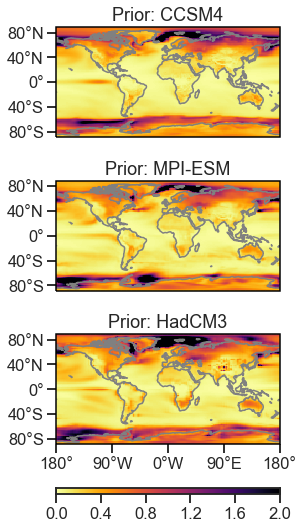

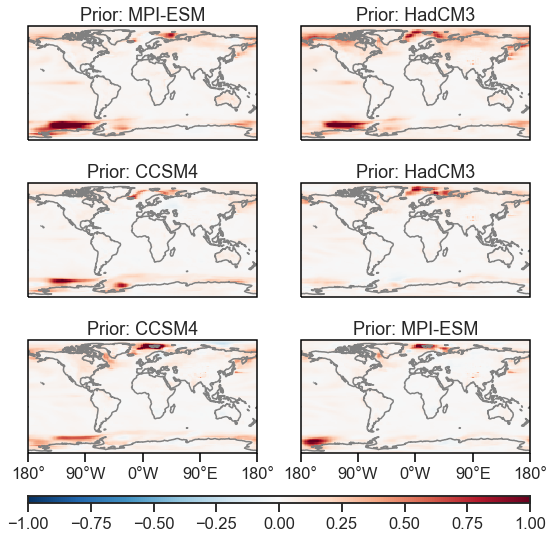

In [50]:
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_var_SNR_'+str(SNR)
plt_var2(cdd,savename)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


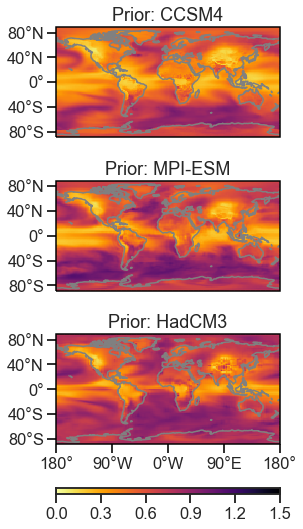

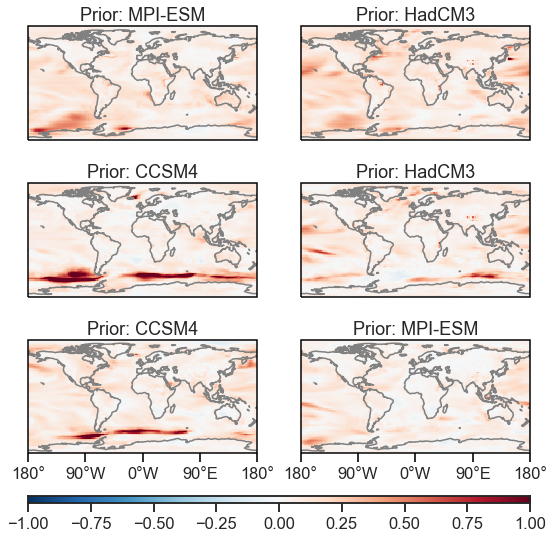

In [120]:
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_NSR_SNR_'+str(SNR)
plt_n2s(cdd,Xd,savename)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


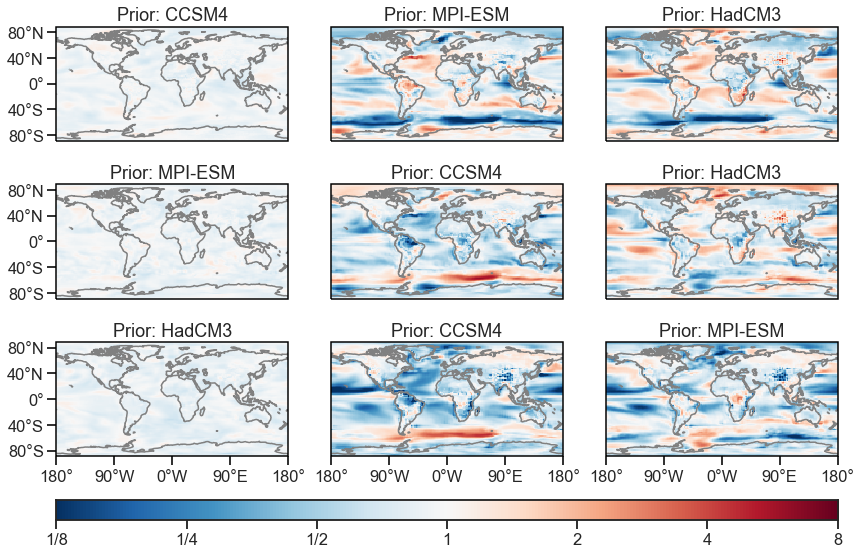

In [147]:
# Load relevant files
SNR = 0.4
#cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_Xa_locrad_0.0.npy')
#Xd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_Xa_locrad_0.0_ad.npy')
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_NE_SNR_'+str(SNR)
plt_NE2(cdd,Xd,savename)


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


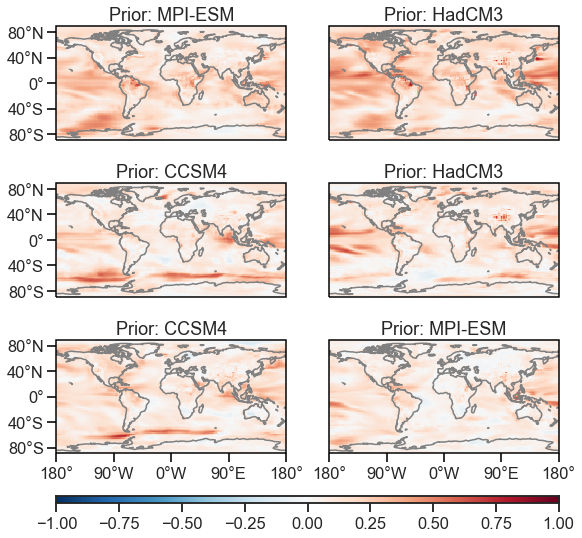

In [53]:
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_FOE_SNR_'+str(SNR)
plt_FOE(cdd,Xd,savename)

# Plot zonal means

In [ ]:
# Load relevant files
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0.npy')
Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0_ad.npy')

CCSM4
CCSM4
MPI-ESM
CCSM4
HadCM3
CCSM4


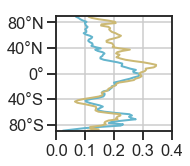

MPI-ESM
MPI-ESM
CCSM4
MPI-ESM
HadCM3
MPI-ESM


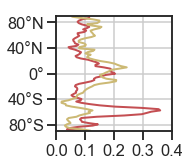

HadCM3
HadCM3
CCSM4
HadCM3
MPI-ESM
HadCM3


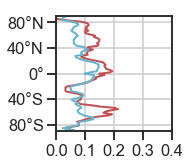

In [59]:
# Zonal means plot of the fraction of error attributed to structural error

SNR = '0.4'

lat = cdd[0]['grid'].lat[:,0]

# This is an array of the results I want to plot. Each column appears on a plot. 
key = np.array([[0,3,6],[1,4,7],[2,5,8]])

# identify which is the truth-truth pair in each column
ttkey = np.array([0,1,2])

colkey = ['r','c','y']
rr = np.empty(2)

for ii in np.arange(3):
    # List of cdd elements appearing in this plot
    keyii = key[:,ii]
    
    # Compute truth variance averaged over the three different realizations
    # This should no longer matter now that all truths are exactly the same.
    Xdmv = np.mean(np.var(Xd[keyii,:,:],2),0).reshape([91,180])
        
    # Define indices that aren't truth-truth pairs
    not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]
    
    # Truth - truth case
    ttr  = np.mean(cdd[keyii[ttkey[ii]]]['rmse'].reshape([91,180])**2,1)
    print(cdd[keyii[ttkey[ii]]]['prior_name'])
    print(cdd[keyii[ttkey[ii]]]['truth_name'])

    # Cases where prior is not the same as truth
    rr0  = np.mean(cdd[keyii[not_tt[0]]]['rmse'].reshape([91,180])**2,1)
    print(cdd[keyii[not_tt[0]]]['prior_name'])
    print(cdd[keyii[not_tt[0]]]['truth_name'])
    
    rr1  = np.mean(cdd[keyii[not_tt[1]]]['rmse'].reshape([91,180])**2,1)
    print(cdd[keyii[not_tt[1]]]['prior_name'])
    print(cdd[keyii[not_tt[1]]]['truth_name'])
    
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot((rr0-ttr)/rr0,lat,colkey[not_tt[0]],linewidth=2)
    plt.plot((rr1-ttr)/rr1,lat,colkey[not_tt[1]],linewidth=2)

    #plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
    plt.xlim([0.,0.4])
    plt.ylim([-90,90])
#    plt.ylabel('Latitude')
#    plt.yticks([-60,-30,0,30,60])
    plt.yticks([-80,-40,0,40,80])
    plt.xticks([0,0.1,0.2,0.3,0.4])
#    ax.set_yticklabels(['60°S','30°S','0°','30°N','60°N'])
    ax.set_yticklabels(['80°S','40°S','0°','40°N','80°N'])
    plt.grid(axis='both')  
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/zonmean_frac_'+cdd[keyii[0]]['truth_name']+'.pdf', bbox_inches='tight')
    plt.show()


# Create swarm plots showing errors of regional means

In [154]:
# Load relevant files
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0.npy')
Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_0.0_ad.npy')

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


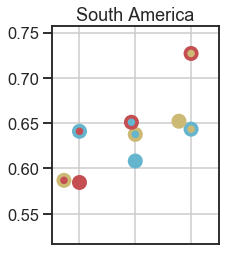

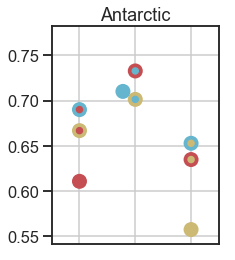

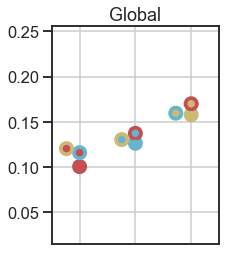

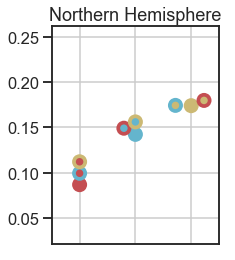

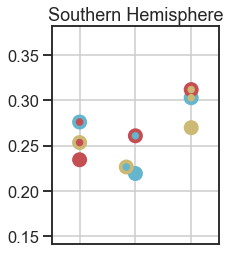

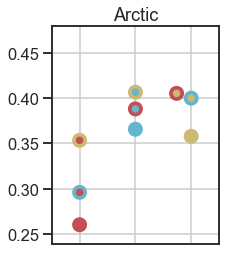

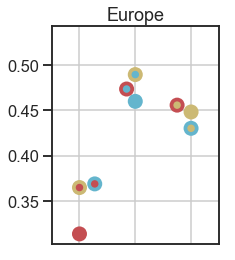

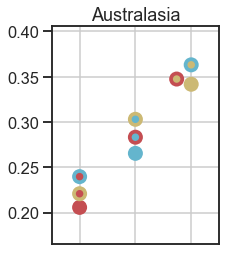

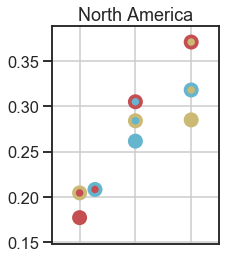

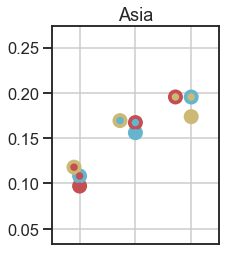

In [171]:
# Plot NSR

sns.set(style='ticks', context='talk')

regnamesl = ['S. America', 'Antarctic']
regnamess = ['Global','NH','SH','Arctic','Europe','Australasia','N. America','Asia',]

plotnamesl = ['South America', 'Antarctic']
plotnamess = ['Global','Northern Hemisphere','Southern Hemisphere','Arctic','Europe','Australasia','North America','Asia',]

gmpl,gmps = mk_regmeans(cdd,Xd)

for rn in enumerate(regnamesl):
    gmp1 = gmpl[gmpl['region']==rn[1]]
    plot_reg_swarm(gmp1)
    plt.title(plotnamesl[rn[0]])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_avg_'+rn[1]+'.pdf',bbox_inches = "tight")
    
for rn in enumerate(regnamess):
    gmp1 = gmps[gmps['region']==rn[1]]
    plot_reg_swarm(gmp1)
    plt.title(plotnamess[rn[0]])
#    plt.title(rn[1])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_avg_'+rn[1]+'.pdf',bbox_inches = "tight")


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


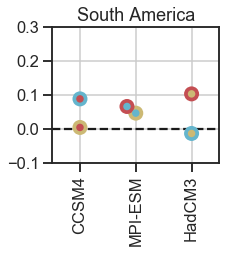

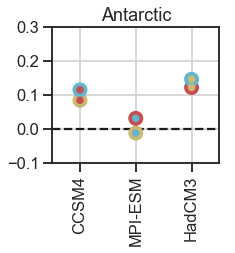

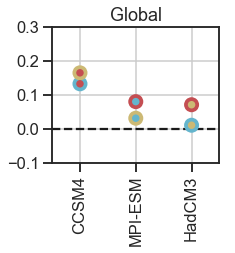

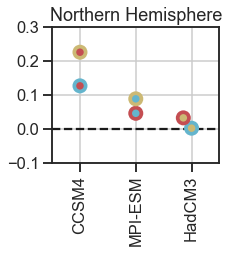

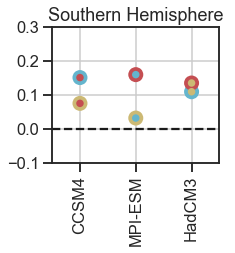

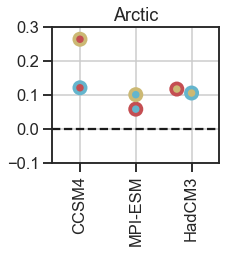

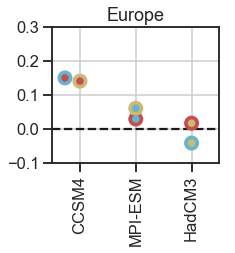

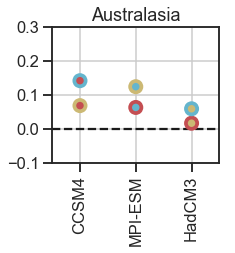

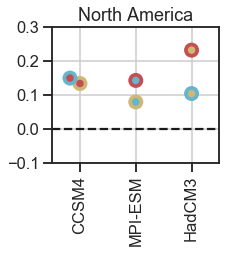

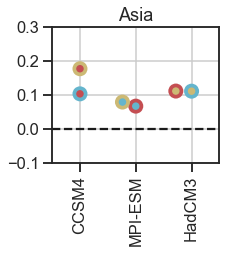

In [132]:
# Plot FOE

sns.set(style='ticks', context='talk')

regnamesl = ['S. America', 'Antarctic']
regnamess = ['Global','NH','SH','Arctic','Europe','Australasia','N. America','Asia',]

plotnamesl = ['South America', 'Antarctic']
plotnamess = ['Global','Northern Hemisphere','Southern Hemisphere','Arctic','Europe','Australasia','North America','Asia',]

gmpl,gmps = mk_regmeans(cdd,Xd)

for rn in enumerate(regnamesl):
    gmp1 = gmpl[gmpl['region']==rn[1]]
    plot_reg_swarm_foe(gmp1)
    plt.title(plotnamesl[rn[0]])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_FoE_'+rn[1]+'.pdf',bbox_inches = "tight")
    
for rn in enumerate(regnamess):
    gmp1 = gmps[gmps['region']==rn[1]]
    plot_reg_swarm_foe(gmp1)
    plt.title(plotnamess[rn[0]])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_FoE_'+rn[1]+'.pdf',bbox_inches = "tight")


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


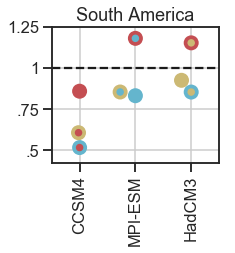

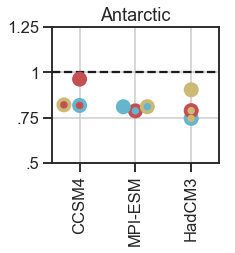

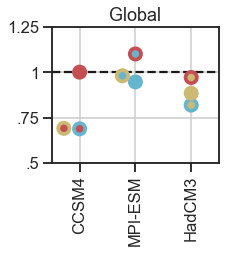

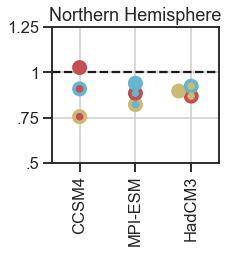

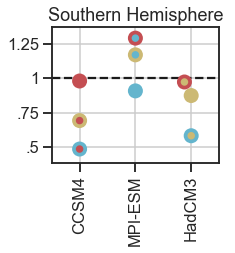

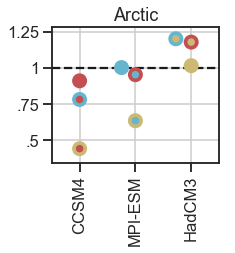

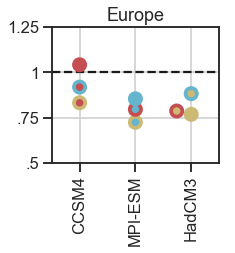

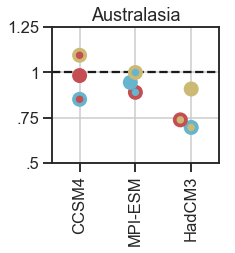

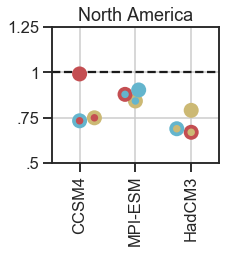

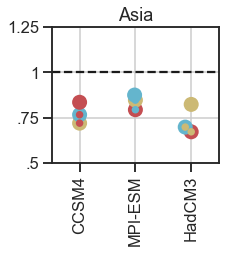

In [153]:
# Plot Pa variance normalized by error

sns.set(style='ticks', context='talk')

regnamesl = ['S. America', 'Antarctic']
regnamess = ['Global','NH','SH','Arctic','Europe','Australasia','N. America','Asia',]

plotnamesl = ['South America', 'Antarctic']
plotnamess = ['Global','Northern Hemisphere','Southern Hemisphere','Arctic','Europe','Australasia','North America','Asia',]

gmpl,gmps = mk_regmeans_Xa(cdd,Xd)

for rn in enumerate(regnamesl):
    gmp1 = gmpl[gmpl['region']==rn[1]]
    plot_reg_swarm_NE(gmp1)
    plt.title(plotnamesl[rn[0]])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_NE_'+rn[1]+'.pdf',bbox_inches = "tight")
    
for rn in enumerate(regnamess):
    gmp1 = gmps[gmps['region']==rn[1]]
    plot_reg_swarm_NE(gmp1)
    plt.title(plotnamess[rn[0]])
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_NE_'+rn[1]+'.pdf',bbox_inches = "tight")


In [18]:
# Load and interpolate all of the priors I want to use as truth
# NB that this is just for grids etc. for now... everything else is stored in files that must be loaded.

lmr_names = ['ccsm4_last_millenium.300',
             'mpi-esm-p_last_millenium.300',
             'hadcm3_last_millenium.300']
model_names = ['CCSM4','MPI-ESM','HadCM3']

ad=mk_ad(lmr_names,model_names)

Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 300 ensemble members
regridding prior...
0 55295
(55296, 300)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -7.9337639808654785 8.361244201660156 0.01795737092932977 0.8233300684750144
=> Truncated array: -7.926461268019282 8.

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


17.256585842836973


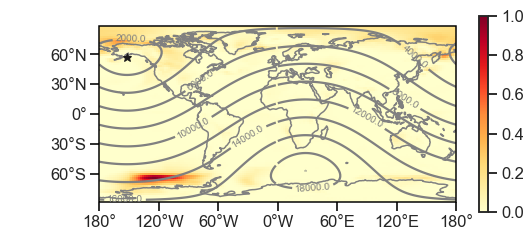

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/nu

98.03584545847178


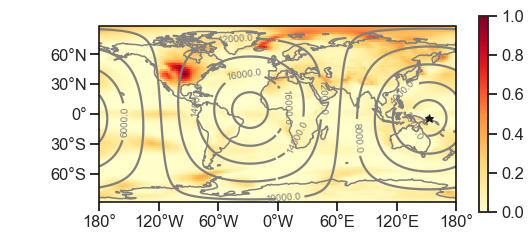

In [136]:
drange,r0 = mkresplot(ad,141)
plt.show()
drange,r1 = mkresplot(ad,418) # eq
plt.show()

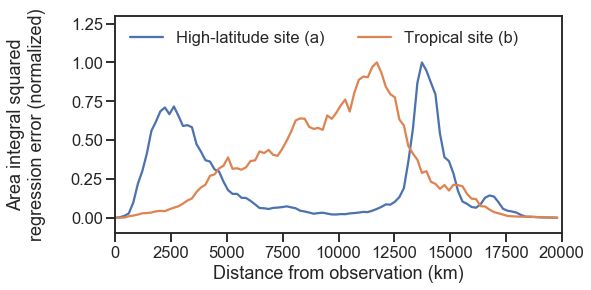

In [142]:
#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(8,4))
plt.plot(drange[:-1],np.array(r0)/np.nanmax(np.array(r0)))
plt.plot(drange[:-1],np.array(r1)/np.nanmax(np.array(r1)))
#plt.plot(drange[:-1],np.array(r2))
plt.ylabel('Area integral squared\nregression error (normalized)\n')
plt.xlabel('Distance from observation (km)')
plt.xlim([0,20000])
plt.ylim([-.1,1.3])
plt.legend(['High-latitude site (a)', 'Tropical site (b)'],
           frameon=False,loc='upper left',ncol=2)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/reg_error_rad.pdf',bbox_inches = "tight")
plt.show()

# Create swarm plots showing sensitivity to localization

In [258]:
# Create pandas dataframe to use in swarm plot

SNR = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0']

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])

for ii,LOCRAD in enumerate(LOCRADs):

    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_locrad_'+LOCRAD+'.npy')
    lat = cdd[0]['grid'].lat

    for jj in np.arange(len(cdd)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd[jj]['prior_name'],cdd[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd[jj]['prior_name'],
                            "truth_name":cdd[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




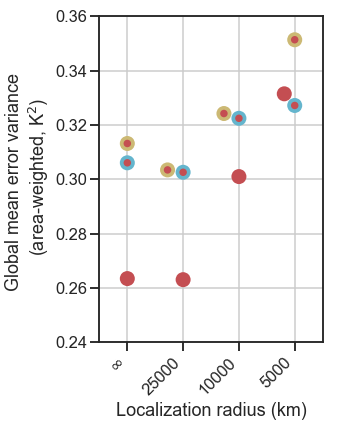

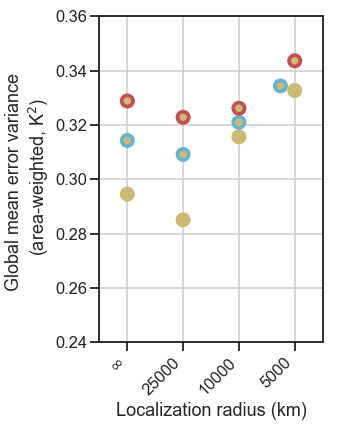

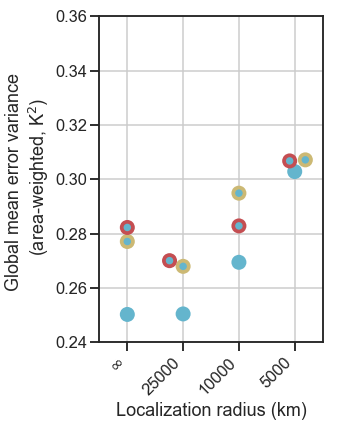

In [266]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/prelims/gm_rmse_gumball_CCSM4.pdf', bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='HadCM3']
plotswarm(gmp2,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/prelims/gm_rmse_gumball_HADCM3.pdf', bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm(gmp3,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/prelims/gm_rmse_gumball_MPI-ESM.pdf', bbox_inches='tight')

# Plot maps to investigate what is going on with UQ under/overestimation

In [176]:
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_Xa_locrad_0.0.npy')
Xd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_Xa_locrad_0.0_ad.npy')



In [177]:
# Plot Pa variance

def plt_Pa(cdd,Xd,savename):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(14,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,3),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = np.arange(9)

    #switch = [0,3,6,1,4,7,2,5,8]
    switch = [0,1,2,4,3,5,8,6,7]
    for ii, ax in enumerate(axgr):
        jj = switch[ii]
        
        rmsc = np.log2(np.std(cdd[tt_ax[jj]]['Xa'],1)**2)

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=3.,vmin=-3.,
                        transform=projection,
                        cmap='RdBu_r',
                        )
        
        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['tind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

#        if cdd[jj]['pind']!=0:
        if cdd[jj]['pind']!=cdd[jj]['tind']:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                right=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    cb.ax.set_xticks(np.log2(np.array([1/8,1/4,1/2,1,2,4,8])))
    cb.ax.set_xticklabels(['1/8','1/4','1/2','1','2','4','8'])

    plt.savefig(savename+'.png',bbox_inches='tight',dpi=300)
    plt.show()

In [189]:
# Plot prior/truth variance ratios

def plt_PTVR(cdd,Xd,savename):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(14,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,3),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = np.arange(9)

    switch = [0,1,2,4,3,5,8,6,7]
    #switch = [0,3,6,1,4,7,2,5,8]
    for ii, ax in enumerate(axgr):
        jj = switch[ii]
        
        # prior var / truth var
        rmsc = np.log2(cdd[jj]['Xbppstd']**2/ cdd[jj]['Xbptstd']**2)

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=3.,vmin=-3.,
                        transform=projection,
                        cmap='RdBu_r',
                        )
        
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])
        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['tind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

#        if cdd[jj]['pind']!=0:
        if cdd[jj]['pind']!=cdd[jj]['tind']:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                right=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    #cb.ax.set_xticks(np.log2(np.array([1/4,1/2,1,2,4])))
    #cb.ax.set_xticklabels(['1/4','1/2','1','2','4'])
    cb.ax.set_xticks(np.log2(np.array([1/8,1/4,1/2,1,2,4,8])))
    cb.ax.set_xticklabels(['1/8','1/4','1/2','1','2','4','8'])
    #cb.ax.set_xticks(np.log10(np.array([1/10,1/5,1/2,1,2,5,10])))
    #cb.ax.set_xticklabels(['1/10','1/5','1/2','1','2','5','10'])


    plt.savefig(savename+'.png',bbox_inches='tight',dpi=300)
    plt.show()
    
#    bins    = np.linspace(-8,8,100)
#    bincs   = bins[:-1]+np.median(np.diff(bins))
#    counts  = np.empty([9,len(bins)-1])
    
#    for jj in np.arange(9):
#        hists = ((cdd[jj]['recon']-Xd[jj])/np.std(cdd[jj]['Xa'],1)[:,None]).ravel()
#        counts[jj,:] = np.histogram(hists,bins)[0]
#    plt.plot(bincs,counts.T)
#    plt.show()
#    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)
#    return bincs, counts

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


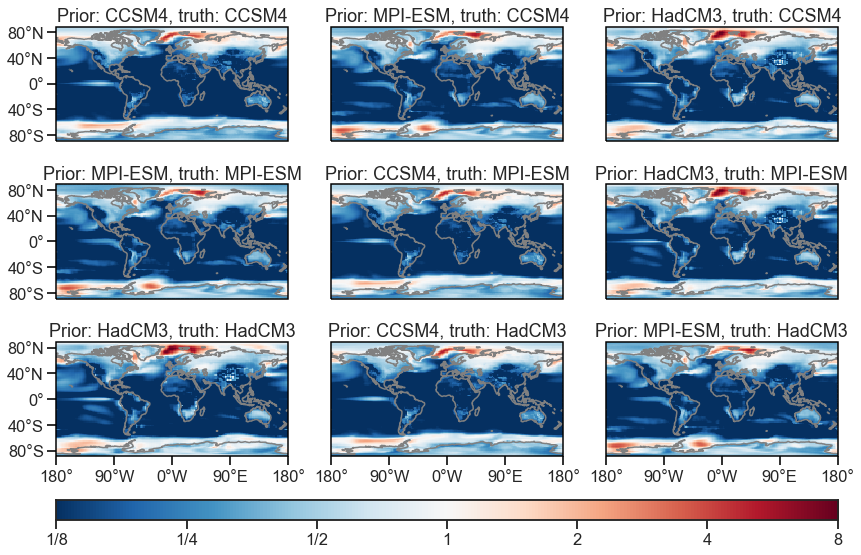

In [182]:
# Plot posterior variance for all 9 experiments
plt_Pa(cdd,Xd,savename)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


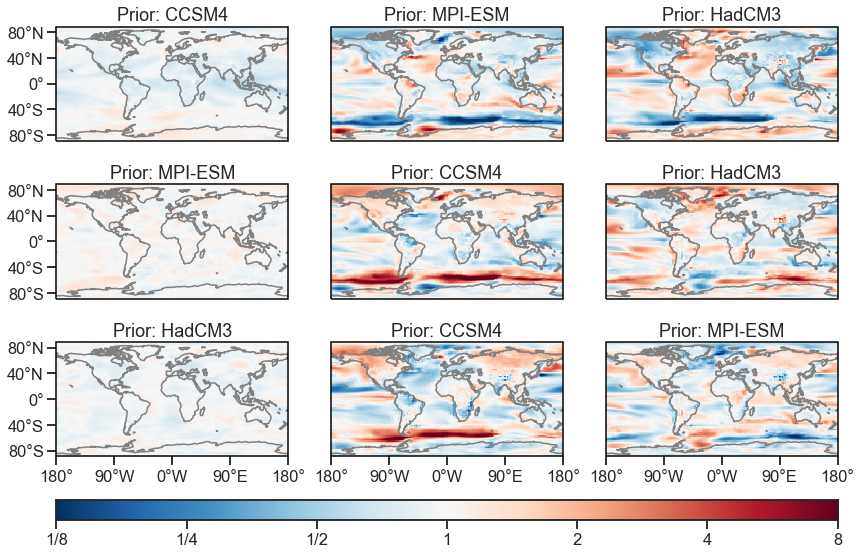

In [190]:
# Plot prior/truth variance ratios for all 9
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_PTVR_SNR_'+str(SNR)
plt_PTVR(cdd,Xd,savename)

In [ ]:
# How does unc'ty under/over estimation change during DA? Take the ratio of PTVR vs NE


In [195]:
# Plot prior/truth variance ratios

def plt_rat_test(cdd,Xd,savename):
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    
    grid = cdd[0]['grid']

    fig = plt.figure(figsize=(14,16))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3,3),
                    axes_pad=0.6,
                    cbar_location='bottom',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=-0.,
                    cbar_size='6%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    tt_ax = np.arange(9)

    switch = [0,1,2,4,3,5,8,6,7]
    #switch = [0,3,6,1,4,7,2,5,8]
    for ii, ax in enumerate(axgr):
        jj = switch[ii]
        
        # prior var / truth var
        rmsc = np.log2((np.std(cdd[jj]['Xa'],1)**2 /cdd[jj]['rmse']**2)/(cdd[jj]['Xbppstd']**2/ cdd[jj]['Xbptstd']**2))
        #rmsc = np.log2()



        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=3.,vmin=-3.,
                        transform=projection,
                        cmap='RdBu_r',
                        )
        
        plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'])
        #plt.title('Prior: '+ cdd[tt_ax[jj]]['prior_name'] + ', truth: ' + cdd[tt_ax[jj]]['truth_name'])

        ax.coastlines(color='gray')
        plt.grid(b=None, which='major', axis='both')
        
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        if cdd[jj]['tind']!=2:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

#        if cdd[jj]['pind']!=0:
        if cdd[jj]['pind']!=cdd[jj]['tind']:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                right=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off


    cb=axgr.cbar_axes[0].colorbar(p)
    #cb.ax.set_xticks(np.log2(np.array([1/4,1/2,1,2,4])))
    #cb.ax.set_xticklabels(['1/4','1/2','1','2','4'])
    cb.ax.set_xticks(np.log2(np.array([1/8,1/4,1/2,1,2,4,8])))
    cb.ax.set_xticklabels(['1/8','1/4','1/2','1','2','4','8'])
    #cb.ax.set_xticks(np.log10(np.array([1/10,1/5,1/2,1,2,5,10])))
    #cb.ax.set_xticklabels(['1/10','1/5','1/2','1','2','5','10'])


#    plt.savefig(savename+'.png',bbox_inches='tight',dpi=300)
    plt.show()
    
#    bins    = np.linspace(-8,8,100)
#    bincs   = bins[:-1]+np.median(np.diff(bins))
#    counts  = np.empty([9,len(bins)-1])
    
#    for jj in np.arange(9):
#        hists = ((cdd[jj]['recon']-Xd[jj])/np.std(cdd[jj]['Xa'],1)[:,None]).ravel()
#        counts[jj,:] = np.histogram(hists,bins)[0]
#    plt.plot(bincs,counts.T)
#    plt.show()
#    plt.savefig(savename+'_2.png',bbox_inches='tight',dpi=300)
#    return bincs, counts

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


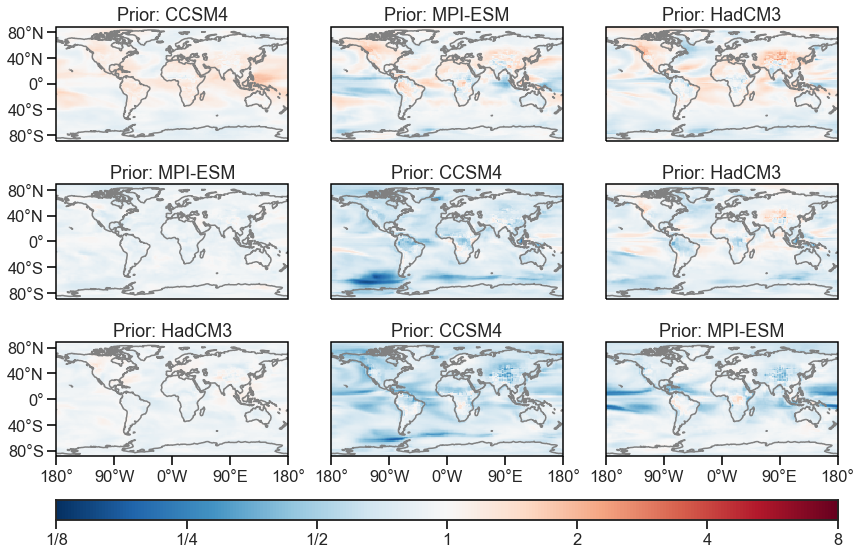

In [196]:
# Plot prior/truth variance ratios for all 9
savename = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_PTVR_SNR_'+str(SNR)
plt_rat_test(cdd,Xd,savename)

# Plot data locations

In [22]:
# Find ob locations
vYe_temp, vYe_coords_temp = mk_yes(ad[0]['X'],ad[0]['Xbp'],ad[0]['prox_manager'],ad[0]['grid'])
#vYe_temp, vYe_coords_temp = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],ad[ii]['prox_manager'],ad[ii]['grid'])


c_dat = np.sum(vYe_temp,1)!=0.
#mask = np.tile(complete.ravel(),[nc,1]).T
#priormask = np.tile(complete.ravel(),[ad[0]['grid'].nens,1]).T
#nanmask = np.ones(np.tile(complete.ravel(),[nc,1]).T.shape)
#nanmask[~mask] = np.nan

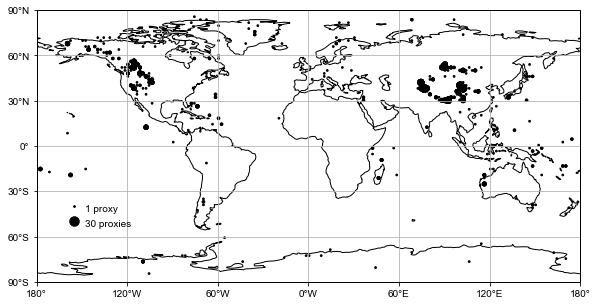

In [23]:
# Plot pproxy data locations
import cartopy.util as cutil
import cartopy.crs as ccrs

npp = np.empty([len(vYe_coords_temp),1])
for ii in np.arange(len(vYe_coords_temp)):
    npp[ii] = np.sum((vYe_coords_temp[:,0]==vYe_coords_temp[ii,0]) & 
                    ((vYe_coords_temp[:,1]==vYe_coords_temp[ii,1])))
    
#vYe_coords_plot = vYe_coords_temp[c_dat,:]

fig = plt.figure(figsize=(10,5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
ax.coastlines()
ax.scatter(vYe_coords_temp[:,1]+2.5,vYe_coords_temp[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
#ax.scatter(vYe_coords_plot[:,1]+2.5,vYe_coords_plot[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.scatter(-155,-40,s=3,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.scatter(-155,-50,s=90,transform=ccrs.PlateCarree(central_longitude=0.),c='k')
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'30 proxies')

#ax.pcolor(wrap_lon,grid.lat[:,0],~wrap_data,cmap='bone',vmin = -7)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/pproxy_locs.pdf')
plt.show()




# Create swarm plot showing sensitivity to SNR

In [137]:
# Create pandas dataframe to use in swarm plot

# indices of truth-truth experiments corresponding to each prior-truth (to use for FOE)
tti  = np.array([0, 0, 0, 4, 4, 4, 8, 8, 8])

#SNRs = ['0.001','0.005','0.01','0.05','0.1','0.2','0.4','0.8','1.6','3.2','6.4','12.8','25.0','50.0','100.0','200.0',
#       '400.0','1000.0','2000.0']
#LOCRADs = ['0.0','25000.0','10000.0','5000.0']
SNRs = ['0.005','0.01','0.05','0.1','0.2','0.4','0.8','1.6','3.2','6.4','12.8','25.0','50.0']
LOCRAD = '0.0'

gmp = pd.DataFrame(columns=['gmv','foegm','SNR','SNRind','prior_name','truth_name','perfect_prior'])

for ii,SNR in enumerate(SNRs):

    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_'+LOCRAD+'_SNR_'+SNR+'.npy')
    lat = cdd[0]['grid'].lat

    for jj in np.arange(len(cdd)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        if jj == tti[jj]:
            foegm = np.nan
        else:
            foe = (cdd[jj]['rmse']**2-cdd[tti[jj]]['rmse']**2)/cdd[jj]['rmse']**2
            foegm = np.sum(np.cos(np.deg2rad(lat.ravel()))*foe)/np.sum(np.cos(np.deg2rad(lat)))
        
        nee = pd.DataFrame({"gmv":[gm],
                            "foegm":[foegm],
                            "SNR":SNR,
                            "SNRind":ii,
                            "prior_name":cdd[jj]['prior_name'],
                            "truth_name":cdd[jj]['truth_name'],
                            "perfect_prior":False
                           })
        gmp=gmp.append(nee)

In [138]:
for ii,SNR in enumerate(SNRs):

    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_perfect_locrad_'+LOCRAD+'_SNR_'+SNR+'.npy')
    lat = cdd[0]['grid'].lat

    for jj in np.arange(len(cdd)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))

        nee = pd.DataFrame({"gmv":[gm],
                            "foegm":[np.NaN],
                            "SNR":SNR,
                            "SNRind":ii,
                            "prior_name":'Perfect',
                            "truth_name":cdd[jj]['truth_name'], 
                            "perfect_prior":True
                           })
        gmp=gmp.append(nee)

In [204]:
def plotswarm_snr(gmp,col):
    si = 15
    fig = plt.figure(figsize=(5,8))
    sns.swarmplot(data=gmp,x="SNRind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y","g"])
    ax=sns.swarmplot(data=gmp,x="SNRind", y="gmv", hue="truth_name",size=si,marker='.',palette=[col])
    plt.xticks(np.arange(len(SNRs)),SNRs)
    plt.xlabel('Data signal-to-noise ratio')
    plt.xticks(rotation=45,ha="right")
    plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([-.05,.8])
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.2, .7), loc=2, borderaxespad=0.,frameon=True)
    #plt.tight_layout()
    
    # For final paper figure
    plt.grid()
    ax.legend_.remove()



In [205]:
def plotswarm_foe_snr(gmp,col):
    si = 15
    fig = plt.figure(figsize=(5,3))
    sns.swarmplot(data=gmp,x="SNRind", y="foegm", hue="prior_name",size=si,marker='o',palette=["r", "c", "y","g"])
    ax=sns.swarmplot(data=gmp,x="SNRind", y="foegm", hue="truth_name",size=si,marker='.',palette=[col])
    plt.xticks(np.arange(len(SNRs)),SNRs)
    plt.xlabel('Data signal-to-noise ratio')
    plt.xticks(rotation=45,ha="right")
    plt.ylabel('Global mean\nfraction of total error')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([-.05,.6])
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.2, .7), loc=2, borderaxespad=0.,frameon=True)
    #plt.tight_layout()
    
    # For final paper figure
    plt.grid()
    ax.legend_.remove()



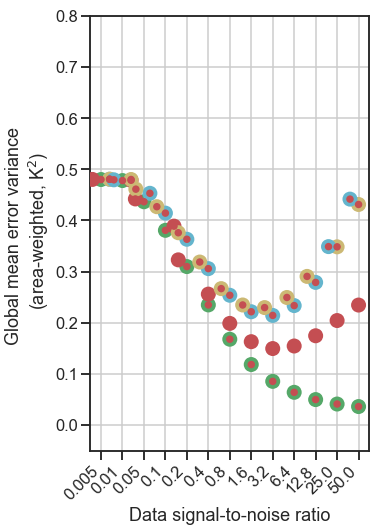

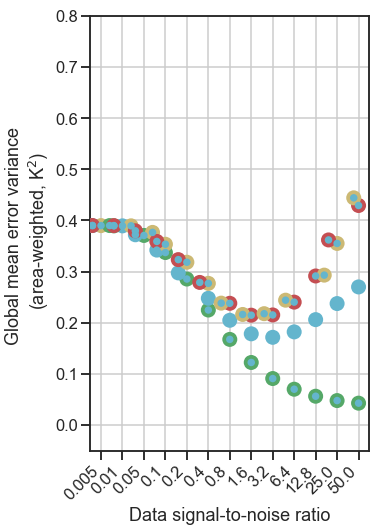

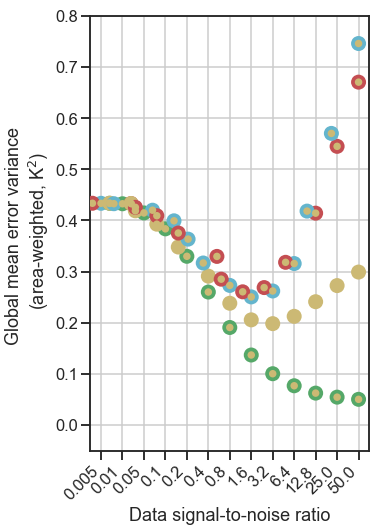

In [206]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm_snr(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_CCSM4.pdf',bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm_snr(gmp2,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_MPI-ESM.pdf',bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='HadCM3']
plotswarm_snr(gmp3,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_HadCM3.pdf',bbox_inches='tight')

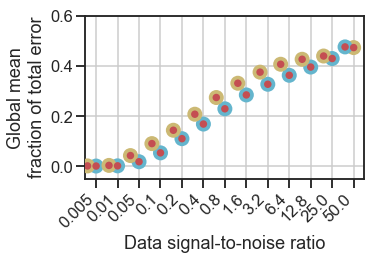

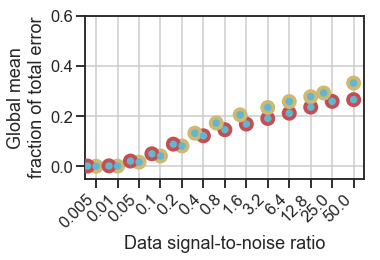

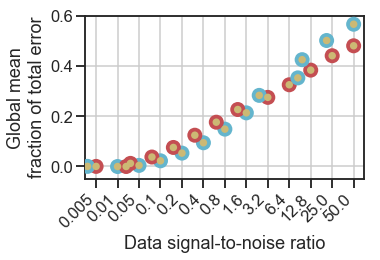

In [203]:
gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm_foe_snr(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_FTE_CCSM4.pdf',bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm_foe_snr(gmp2,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_FTE_MPI-ESM.pdf',bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='HadCM3']
plotswarm_foe_snr(gmp3,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_FTE_HadCM3.pdf',bbox_inches='tight')

# Plot variance-scaled maps

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


CCSM4
CCSM4
MPI-ESM
CCSM4
HadCM3
CCSM4


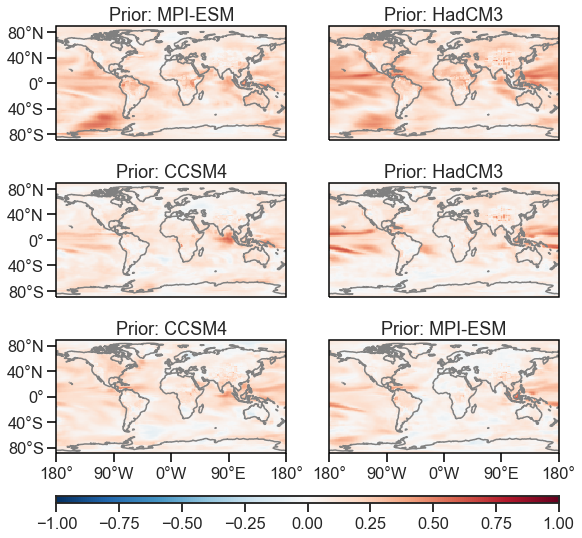

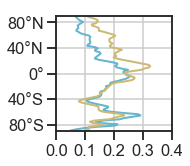

MPI-ESM
MPI-ESM
CCSM4
MPI-ESM
HadCM3
MPI-ESM


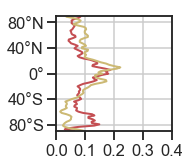

HadCM3
HadCM3
CCSM4
HadCM3
MPI-ESM
HadCM3


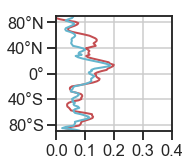

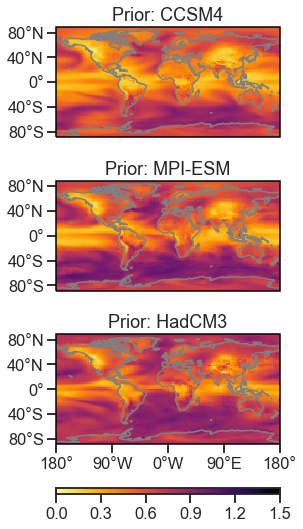

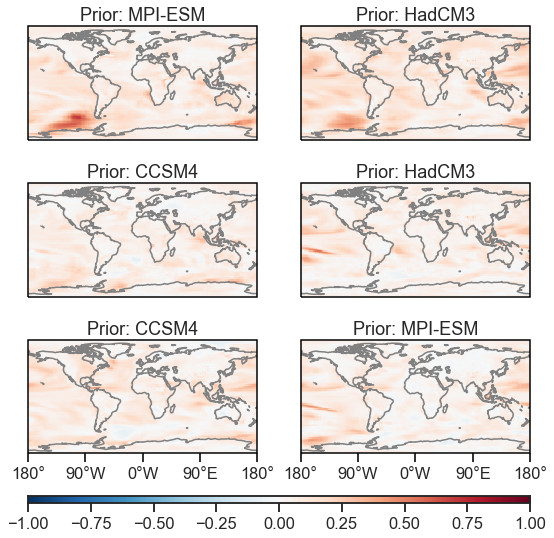

In [201]:
# Load files
SNR = 0.4
cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_scale_prior_locrad_0.0.npy')
Xd   = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_scale_prior_locrad_0.0_ad.npy')
savekey = '_scale_prior'

savename1 = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_FOE'+savekey+'_SNR_'+str(SNR)
plt_FOE(cdd,Xd,savename1)

savename2 = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/zonmean_frac'+savekey+'_SNR_'+str(SNR)+'_'
plt_zonmean(cdd,Xd,savename2)

savename3 = '/Users/dan/Desktop/Nullspace_Figs3/Prelims/map_NSR'+savekey+'_SNR_'+str(SNR)
plt_n2s(cdd,Xd,savename3)

# Create swarm plot showing sensitivity to SNR -- now localized at 25k km

In [208]:
# Create pandas dataframe to use in swarm plot

# indices of truth-truth experiments corresponding to each prior-truth (to use for FOE)
tti  = np.array([0, 0, 0, 4, 4, 4, 8, 8, 8])

#SNRs = ['0.001','0.005','0.01','0.05','0.1','0.2','0.4','0.8','1.6','3.2','6.4','12.8','25.0','50.0','100.0','200.0',
#       '400.0','1000.0','2000.0']
#LOCRADs = ['0.0','25000.0','10000.0','5000.0']
#SNRs = ['0.005','0.01','0.05','0.1','0.2','0.4','0.8','1.6','3.2','6.4','12.8','25.0','50.0']
SNRs = ['0.05','0.4','1.6','3.2','6.4','25.0']
LOCRAD = '25000.0'

gmp = pd.DataFrame(columns=['gmv','foegm','SNR','SNRind','prior_name','truth_name','perfect_prior'])

for ii,SNR in enumerate(SNRs):

    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_locrad_'+LOCRAD+'_SNR_'+SNR+'.npy')
    lat = cdd[0]['grid'].lat

    for jj in np.arange(len(cdd)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        if jj == tti[jj]:
            foegm = np.nan
        else:
            foe = (cdd[jj]['rmse']**2-cdd[tti[jj]]['rmse']**2)/cdd[jj]['rmse']**2
            foegm = np.sum(np.cos(np.deg2rad(lat.ravel()))*foe)/np.sum(np.cos(np.deg2rad(lat)))
        
        nee = pd.DataFrame({"gmv":[gm],
                            "foegm":[foegm],
                            "SNR":SNR,
                            "SNRind":ii,
                            "prior_name":cdd[jj]['prior_name'],
                            "truth_name":cdd[jj]['truth_name'],
                            "perfect_prior":False
                           })
        gmp=gmp.append(nee)

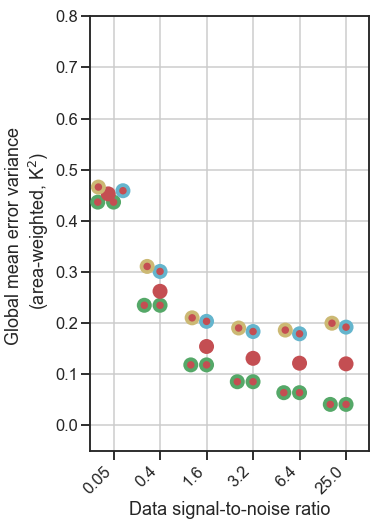

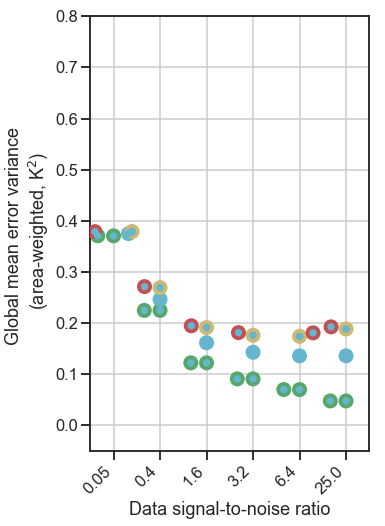

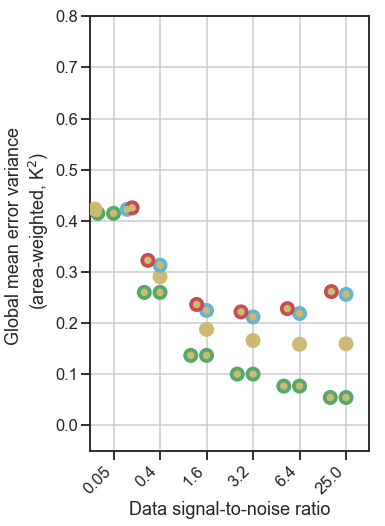

In [214]:
sns.set(style='ticks', context='talk')

gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm_snr(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_CCSM4.pdf',bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm_snr(gmp2,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_MPI-ESM.pdf',bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='HadCM3']
plotswarm_snr(gmp3,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_HadCM3.pdf',bbox_inches='tight')

In [213]:
for ii,SNR in enumerate(SNRs):

    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_400_rand_draws_one_truth_perfect_locrad_0.0_SNR_'+SNR+'.npy')
    lat = cdd[0]['grid'].lat

    for jj in np.arange(len(cdd)):

        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))

        nee = pd.DataFrame({"gmv":[gm],
                            "foegm":[np.NaN],
                            "SNR":SNR,
                            "SNRind":ii,
                            "prior_name":'Perfect',
                            "truth_name":cdd[jj]['truth_name'], 
                            "perfect_prior":True
                           })
        gmp=gmp.append(nee)

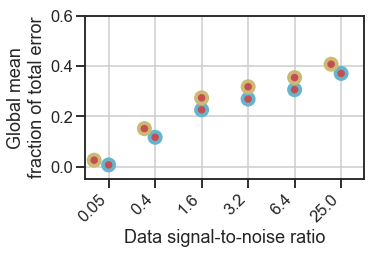

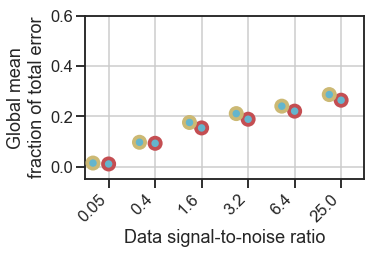

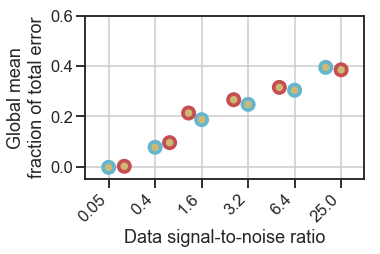

In [212]:
gmp1 = gmp[gmp['truth_name']=='CCSM4']
plotswarm_foe_snr(gmp1,"r")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_FTE_CCSM4.pdf',bbox_inches='tight')

gmp2 = gmp[gmp['truth_name']=='MPI-ESM']
plotswarm_foe_snr(gmp2,"c")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_FTE_MPI-ESM.pdf',bbox_inches='tight')

gmp3 = gmp[gmp['truth_name']=='HadCM3']
plotswarm_foe_snr(gmp3,"y")
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/SNRsens_25k_FTE_HadCM3.pdf',bbox_inches='tight')